### Preparing environment

In [ ]:
!pip3 install --quiet datasets spacy pystemmer matplotlib numpy sklearn
!python3 -m spacy download en_core_web_sm

You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
     |████████████████████████████████| 13.7 MB 3.0 MB/s 
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
from collections import Counter
from typing import List, Tuple
import re

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from datasets import load_dataset
import spacy
from Stemmer import Stemmer

spacy_nlp = spacy.load('en_core_web_sm')
stemmer = Stemmer('english')

### Loading dataset

In [ ]:
dataset = load_dataset('amazon_reviews_multi', 'en')

Reusing dataset amazon_reviews_multi (/Users/vladtsap/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/f3357bd271e187385a38574fe31b8fb10055303f67fa9fce55e84d08c4870efd)


In [ ]:
dataset.keys()

dict_keys(['train', 'validation', 'test'])

### Set dataset variables

In [ ]:
train_data = dataset['train']
valid_data = dataset['validation']
test_data = dataset['test']

In [ ]:
train_data

Dataset({
    features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
    num_rows: 200000
})

In [ ]:
valid_data

Dataset({
    features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
    num_rows: 5000
})

In [ ]:
train_data[0]

{'language': 'en',
 'product_category': 'furniture',
 'product_id': 'product_en_0740675',
 'review_body': "Arrived broken. Manufacturer defect. Two of the legs of the base were not completely formed, so there was no way to insert the casters. I unpackaged the entire chair and hardware before noticing this. So, I'll spend twice the amount of time boxing up the whole useless thing and send it back with a 1-star review of part of a chair I never got to sit in. I will go so far as to include a picture of what their injection molding and quality assurance process missed though. I will be hesitant to buy again. It makes me wonder if there aren't missing structures and supports that don't impede the assembly process.",
 'review_id': 'en_0964290',
 'review_title': "I'll spend twice the amount of time boxing up the whole useless thing and send it back with a 1-star review ...",
 'reviewer_id': 'reviewer_en_0342986',
 'stars': 1}

### Preprocessing

In [ ]:
STOP_WORDS = [
    'the', 'a', 'an', 'and', 'of', 'to', 'is', 'in', 'that', 'this', 'was', 'as', 'with', 'for', 'you', 'are', 'it', 
    'so', 'be', 'i', 'my', 'they', 'these', 'them', 'just', 'do', 'did', 'at', 'or', 'me', 'too', 'on', '.', ',', '?',
    '!', 'have', 'will', 'would', 'am', 'if', 'when', '-', 'has', 'your', 'some', 'now', 'also', 'which', 'had', 'what',
    '"', 'could', 'can', 'there',
    ]


def tokenize(text: str) -> List[str]:
    disable = ['ner', 'parser', 'tagger', 'lemmatizer', 'tok2vec', 'senter', 'attribute_ruler']
    tokens = spacy_nlp(text, disable=disable)
    return [str(token) for token in tokens]


def stem(tokens: List[str]) -> List[str]:
    tokens = [token.lower() for token in tokens]
    return stemmer.stemWords(tokens)


def deconstruct_word(token: str) -> str:
    token = re.sub(r"n\'t", "not", token)
    token = re.sub(r"\'t", "not", token)
    token = re.sub(r"\'re", "are", token)
    token = re.sub(r"\'s", "is", token)
    token = re.sub(r"\'d", "would", token)
    token = re.sub(r"\'ll", "will", token)
    token = re.sub(r"\'ve", "have", token)
    token = re.sub(r"\'m", "am", token)
    return token


def deconstruct(tokens: List[str]) -> List[str]:
    return [deconstruct_word(token) for token in tokens]


def remove_stop_words(tokens: List[str]) -> List[str]:
    return [token for token in tokens if token not in STOP_WORDS]


def preprocess(text: str) -> List[str]:
    tokens = tokenize(text)
    tokens = stem(tokens)
    tokens = deconstruct(tokens)
    tokens = remove_stop_words(tokens)
    return tokens

### Compare before and after processing

In [ ]:
all_tokens = []
processed_tokens = []
for doc in train_data:
  all_tokens += tokenize(doc['review_body'])
  processed_tokens += preprocess(doc['review_body'])

print("Original unqiue tokens: {:,}".format(len(set(all_tokens))))
print("Processed unique tokens: {:,}".format(len(set(processed_tokens))))

Original unqiue tokens: 64,112
Processed unique tokens: 31,634
Top 100 most common tokens account for 38.16% of tokens
Top 100 tokens are: [('not', 120608), ('but', 76557), ('use', 42517), ('veri', 40783), ('work', 39601), ('like', 36281), ('one', 34506), ('great', 29489), ('good', 28172), ('product', 27179), ('get', 24876), ('all', 23318), ('look', 23143), ('out', 22871), ('doe', 22216), ('up', 22178), ('love', 21805), ('n’t', 20996), ('time', 20383), ('well', 19675), ('onli', 18419), ('fit', 17957), ('from', 17543), ('no', 17302), ('than', 16891), ('after', 16781), ('realli', 16665), ('more', 15947), ('off', 15489), ('were', 15232), ('order', 15194), ('becaus', 15005), ('qualiti', 14906), ('other', 14060), ('nice', 13786), ('littl', 13305), ('we', 13233), ('size', 12958), ('buy', 12841), ('need', 12837), ('about', 12740), ('’s', 12738), ('bought', 12638), ('return', 12317), ('make', 12116), ('tri', 12048), ('even', 11948), ('back', 11697), ('much', 11688), ('easi', 11605), ('small', 

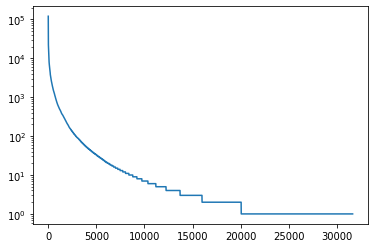

In [ ]:
token_counts = Counter(processed_tokens)

# view top 100 most common
most_common = token_counts.most_common(100)
most_common_count = sum(count for token, count in most_common)
all_count = sum(token_counts.values())
print(f"Top {len(most_common)} most common tokens account for {most_common_count / all_count:.2%} of tokens")
print(f"Top {len(most_common)} tokens are: {most_common}")

plt.yscale("log")
plt.plot(sorted(token_counts.values(), reverse=True))

In [ ]:
VOCAB_SIZE = 5000
MIN_COUNT = 5

vocab_list = [token for token, count in token_counts.most_common() if count > MIN_COUNT]

print(f"Vocab size after filtering: {len(vocab_list):,}")

# cut part of vocab
vocab_list = vocab_list[:VOCAB_SIZE]
print(f"Final vocab size: {len(vocab_list):,}")

Vocab size after filtering: 11,176
Final vocab size: 5,000


### Vocabulary class

In [ ]:
class Vocabulary:

  def __init__(self, tokens, unk_token="<unk>"):
    self.unk_token = unk_token
    self.unk_index = 0
    self._itos = [unk_token] + tokens
    self._stoi = {token: index for index, token in enumerate(self._itos)}

  def stoi(self, token: str) -> int:
    """Return token index or `<unk>` index if `token` is not in the vocab."""
    return self._stoi.get(token, self.unk_index)


  def itos(self, index: int) -> str:
    """Return token by its `index`."""
    return self._itos[index]


  @property
  def tokens(self):
    return self._itos


  def __len__(self) -> int:
    return len(self._itos)

### n-grams

In [ ]:
def extract_ngrams_iter(tokens: List[str], max_n: int, min_n: int = 1) -> List[str]:
    tokens_len = len(tokens)

    for i in range(tokens_len):
        for j in range(min_n, max_n + 1):
            if i+j <= tokens_len:
                ngram = tokens[i:i+j]
                ngram = ' '.join(ngram)
                yield ngram


def extract_ngrams(tokens: List[str], max_n: int, min_n: int = 1) -> List[str]:
    return list(extract_ngrams_iter(tokens, max_n, min_n))


def bag_of_ngrams(tokens: List[str], vocab: Vocabulary) -> List[int]:
    result = [0] * len(vocab)
    ngrams = extract_ngrams(tokens, 2)
    for ngram in ngrams:
        index = vocab.stoi(ngram)
        result[index] += 1
    return result

### Generate ngram vocab

In [ ]:
counts = Counter()
for doc in train_data:
    tokens = preprocess(doc['review_body'])
    ngrams = extract_ngrams(tokens, 2)
    counts.update(ngrams)

ngrams_vocab = [token for token, count in counts.most_common() if count > MIN_COUNT]
ngrams_vocab = ngrams_vocab[:VOCAB_SIZE]
ngrams_vocab = Vocabulary(ngrams_vocab)


### Self-written vectorizer

In [ ]:
def vectorize(data: 'datasets.Dataset') -> Tuple[np.array, np.array]:
    X_list = []
    y_list = []

    for doc in data:
        tokens = preprocess(doc['review_body'])
        X_list.append(bag_of_ngrams(tokens, ngrams_vocab))
        y_list.append(doc['stars'])
    
    X = np.array(X_list)
    y = np.array(y_list)
    return (X, y)

### Vectorize `train` and `valid` data

In [ ]:
X_train, y_train = vectorize(train_data)
X_val, y_val = vectorize(valid_data)

In [ ]:
X_train.shape

(200000, 5001)

### Apply Logistic Regression to train data

In [ ]:
model = LogisticRegression(solver='liblinear', C=0.5, penalty='l1')
model.fit(X_train, y_train)

LogisticRegression(C=0.5, penalty='l1', solver='liblinear')

### model accuracy

In [ ]:
y_pred = model.predict(X_val)
accuracy_score(y_val, y_pred)

0.5344